In [3]:
import numpy as np
import pandas as pd

Let's load the dataset and see what I have.

In [4]:
raw_data = pd.read_csv("diamonds.csv")
raw_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


So the first column is an index, can be safely removed. Also, the price column will be the target here.

In [5]:
data_stripped = raw_data.drop(raw_data.columns[0], axis=1)
data = data_stripped.drop("price", axis=1)
target = data_stripped["price"]

Time to split the sets, and shuffle them, since they seem to be ordered by the price which mi

In [6]:
import sklearn.model_selection
import sklearn.utils

In [7]:
data, target = sklearn.utils.shuffle(data, target)

In [302]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, test_size=0.3)

Let's take a look at the data again.

In [11]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
15425,1.04,Ideal,G,VS2,62.6,55.0,6.45,6.49,4.05
53019,0.76,Very Good,H,VS2,58.7,61.0,5.96,5.99,3.51
38232,0.40,Ideal,H,VS1,62.7,59.0,4.74,4.70,2.96
46933,0.52,Ideal,E,VS2,61.1,55.0,5.27,5.20,3.20
42429,0.55,Ideal,F,SI2,61.1,56.0,5.25,5.33,3.24


It might look like a lot of One-Hot encoding is required here - for the cut, color, and clarity classes.
However, taking look at what they mean:
 - cut - "Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal"
 - color - "Color of the diamond, with D being the best and J the worst"
 - clarity - "How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) ..."
 
It looks like each category can in fact be represented by a single number, beacuse the classes are ordered as well.  
For the cut quality the result is obvious.   
Color is a little more problematic, but a bit of online search yields the following result: as the description states - D is the best, J is the worst, and every letter in between ranks the diamond the same way as letters in the alphabet, so: D > E > F > G ...  
As for the clarity - let's first see what we have.

In [16]:
X_train["clarity"].value_counts()

SI1     9216
VS2     8546
SI2     6472
VS1     5686
VVS2    3527
VVS1    2562
IF      1236
I1       513
Name: clarity, dtype: int64

After a bit more search here is what those categories mean:  
F is flawless - the best one.  
IF is for internally flawless - very hard to view but still there.  
VVS stands for very very flawless
etc.  

So the order of their quality is determined like this:  
FL > IF > VVS1 > VVS2 > VS1 > VS2 > SI1 > SI2 > SI3 > I1 > I2 > I3  
Because this order can be simply determined, I am not going to One-Hot encode this columns, as doing it is losing a part of information.

Now, let's see a histogram of the numerical values and how they relate to the price.

In [17]:
from pandas.plotting import scatter_matrix

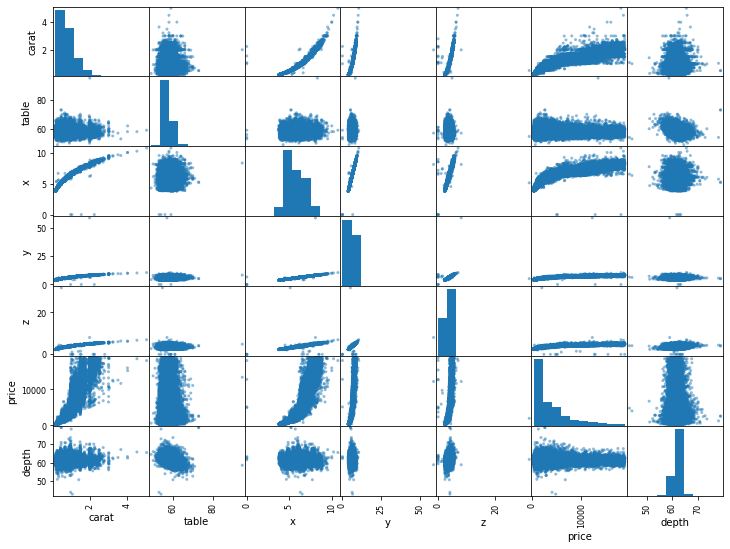

In [23]:
scatter_matrix(X_train.join(y_train)[["carat", "table", "x", "y", "z", "price", "depth"]],
              figsize=(12,9))
pass

As can be seen, price is related with the carats somehow, especially for low prices, and the dimensions in what seems to be an exponential relation.  
Depth and table might somehow affect the price but the relationship is not apparent - what can be seen here is that the values tend to cluster around depth ~ 65 and table ~60. Because this values determine the shape of the diamond, but not it's size, it shoud be expected that they do not affect the price much.

Let's go on and create lists for the ordinal encoder to use.
If it encodes it in an ascending or descending order doesn't matter, but the order must be maintained.

In [106]:
colorsList = [[chr(x) for x in range(ord("D"), ord("Z")+1)]]
cutList = [["Fair", "Good", "Very Good", "Premium", "Ideal"]]
clarityList = [["FL", "IF", "VVS1", "VVS2", "VS1",
               "VS2", "SI1", "SI2", "SI3", "I1", "I2" "I3"]]

Those columns will require an additional pipeline to be preprocessed.

In [107]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [108]:
colorsEncoder = OrdinalEncoder(categories = colorsList)
cutEncoder = OrdinalEncoder(categories = cutList)
clarityEncoder = OrdinalEncoder(categories = clarityList)

Since we have all possible diamond categories in those lists, I want an error if an unknown value is found.
If a value for a diamond is not specified, I will assume it is a "median" quality diamond.

In [109]:
from sklearn.impute import SimpleImputer
catImputer = SimpleImputer(strategy="median")

catEncoders = ColumnTransformer([
    ("colors", colorsEncoder, ["color"]),
    ("cuts", cutEncoder, ["cut"]),
    ("clarity", clarityEncoder, ["clarity"])
])

catPipeline = Pipeline([
    ("encode", catEncoders),
    ("impute", catImputer)
])

For numerical values I want to explore some histograms first.

<AxesSubplot:>

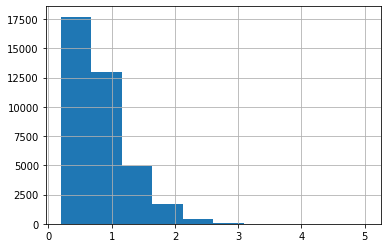

In [110]:
X_train["carat"].hist()

This could be normalized with some logarithm.

<AxesSubplot:>

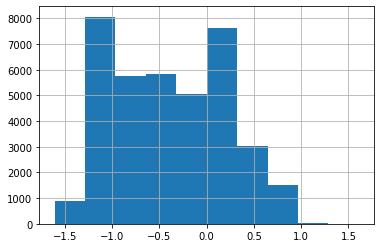

In [111]:
np.log(X_train["carat"]).hist()

Looks a bit more "normal".

The remaining values look kind-of normalized. I won't be normalizing x, y, and z with log, because the tails are mostly outliers.

In [116]:
from sklearn.preprocessing import FunctionTransformer

numTransformer = ColumnTransformer([
    ("logcarat", FunctionTransformer(np.log), ["carat"])
], remainder="passthrough")

In [129]:
from sklearn.preprocessing import StandardScaler

numPipeline = Pipeline([
    ("transform", numTransformer),
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

In [132]:
columns = X_train.columns
numColumns = columns.drop(["clarity", "color", "cut"])
catColumns = columns.drop(numColumns)

fullPipeline = ColumnTransformer([
    ("catPipeline", catPipeline, catColumns),
    ("numPipeline", numPipeline, numColumns)
])

Let's try running the pipeline now.

In [134]:
X_train_transformed = fullPipeline.fit_transform(X_train)

Looks promising.

Since some exponential dependencies can be seen in the data I will skip training a LinearRegression model for a while. First, I'll try a SVM with a gaussian kernel, since the number of attributes is not high.

In [226]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

In [259]:
svr = LinearSVR()
svr_params = {
    "C" : np.logspace(-8, 8, 5),
    "epsilon" : np.logspace(-30, 1, 5),
    "max_iter" : [15000]
}

search = GridSearchCV(svr, param_grid=svr_params, scoring="neg_mean_squared_error",
                     cv=3, n_jobs=8, verbose=2)

In [260]:
search.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3, estimator=LinearSVR(), n_jobs=8,
             param_grid={'C': array([1.e-08, 1.e-04, 1.e+00, 1.e+04, 1.e+08]),
                         'epsilon': array([1.00000000e-30, 5.62341325e-23, 3.16227766e-15, 1.77827941e-07,
       1.00000000e+01]),
                         'max_iter': [15000]},
             scoring='neg_mean_squared_error', verbose=2)

In [261]:
np.sqrt(-search.best_score_)

2155.9941472601536

In [262]:
search.best_estimator_

LinearSVR(epsilon=1e-30, max_iter=15000)

In [161]:
from sklearn.ensemble import RandomForestRegressor

In [166]:
rfr = RandomForestRegressor()
frf_params = {
    "n_estimators" : np.linspace(10, 100, 10, dtype=int),
    "min_samples_split" : [2, 4, 6, 10],
    "max_depth" : np.linspace(30, 100, 10, dtype=int)
}

search = GridSearchCV(rfr, param_grid=frf_params, scoring="neg_mean_squared_error",
                     cv=3, n_jobs=8, verbose=2)

In [167]:
search.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'max_depth': array([ 30,  37,  45,  53,  61,  68,  76,  84,  92, 100]),
                         'min_samples_split': [2, 4, 6, 10],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='neg_mean_squared_error', verbose=2)

In [168]:
np.sqrt(-search.best_score_)

556.3843308997098

In [169]:
search.best_estimator_

RandomForestRegressor(max_depth=76, min_samples_split=6, n_estimators=90)

The random forest regressor looks promising. Just to be sure, I will try linear regression as well. For faster search, I'm going to create a transformer with number of features as a parameter.

In [252]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import Ridge

class PolyRidge(Ridge, BaseEstimator, TransformerMixin):
    def __init__(self, polyE = 2, alpha=1.0, *, fit_intercept=True,
                 normalize=False, copy_X=True, max_iter=None,
                 tol=0.001, solver='auto', random_state=None):
        self.polyE = polyE
        super().__init__(alpha=alpha, fit_intercept=fit_intercept, normalize=normalize,
                         copy_X=copy_X, max_iter=max_iter, tol=tol, solver=solver, random_state=random_state)
        
        
    def fit(self, X, y):
        self.polyTransformer = PolynomialFeatures(degree = self.polyE)
        polyX = self.polyTransformer.fit_transform(X)
        return super().fit(polyX, y)
    
    def predict(self, X):
        polyX = self.polyTransformer.transform(X)
        return super().predict(polyX)        

In [255]:

linreg_params = {
    "alpha" : np.logspace(-12, 12, 30),
    "polyE" : [1, 2, 3]
}

linreg = PolyRidge(normalize=True)
search = GridSearchCV(linreg, linreg_params, verbose = 2,
                     n_jobs=8, scoring="neg_mean_squared_error", cv = 3)

In [256]:
search.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3, estimator=PolyRidge(normalize=True), n_jobs=8,
             param_grid={'alpha': array([1.00000000e-12, 6.72335754e-12, 4.52035366e-11, 3.03919538e-10,
       2.04335972e-09, 1.37382380e-08, 9.23670857e-08, 6.21016942e-07,
       4.17531894e-06, 2.80721620e-05, 1.88739182e-04, 1.26896100e-03,
       8.53167852e-03, 5.73615251e-02, 3.85662042e-01, 2.59294380e+00,
       1.74332882e+01, 1.17210230e+02, 7.88046282e+02, 5.29831691e+03,
       3.56224789e+04, 2.39502662e+05, 1.61026203e+06, 1.08263673e+07,
       7.27895384e+07, 4.89390092e+08, 3.29034456e+09, 2.21221629e+10,
       1.48735211e+11, 1.00000000e+12]),
                         'polyE': [1, 2, 3]},
             scoring='neg_mean_squared_error', verbose=2)

In [257]:
np.sqrt(-search.best_score_)

1708.3027886066036

In [258]:
search.best_estimator_

PolyRidge(alpha=0.05736152510448681, normalize=True, polyE=1)

Doesn't look like polynomial features help at all. Let's go back to the random forest regressor.

In [265]:
rfr = RandomForestRegressor()
frf_params = {
    "n_estimators" : np.linspace(80, 120, 20, dtype=int),
    "min_samples_split" : [4, 5, 6, 7, 8, 9],
    "max_depth" : np.linspace(50, 100, 10, dtype=int)
}

search = GridSearchCV(rfr, param_grid=frf_params, scoring="neg_mean_squared_error",
                     cv=3, n_jobs=8, verbose=2)

In [266]:
search.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'max_depth': array([ 50,  55,  61,  66,  72,  77,  83,  88,  94, 100]),
                         'min_samples_split': [4, 5, 6, 7, 8, 9],
                         'n_estimators': array([ 80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 101, 103, 105,
       107, 109, 111, 113, 115, 117, 120])},
             scoring='neg_mean_squared_error', verbose=2)

In [267]:
np.sqrt(-search.best_score_)

554.9631375695212

In [268]:
search.best_estimator_

RandomForestRegressor(max_depth=66, min_samples_split=7, n_estimators=113)

In [269]:
rfr = RandomForestRegressor()
frf_params = {
    "n_estimators" : np.linspace(100, 120, 20, dtype=int),
    "min_samples_split" : [6, 7, 8],
    "max_depth" : np.linspace(60, 70, 10, dtype=int)
}

search = GridSearchCV(rfr, param_grid=frf_params, scoring="neg_mean_squared_error",
                     cv=3, n_jobs=8, verbose=2)

In [270]:
search.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'max_depth': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 70]),
                         'min_samples_split': [6, 7, 8],
                         'n_estimators': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 120])},
             scoring='neg_mean_squared_error', verbose=2)

In [271]:
np.sqrt(-search.best_score_)

554.8177822888259

In [272]:
search.best_estimator_

RandomForestRegressor(max_depth=60, min_samples_split=8, n_estimators=109)

Let's try training it on the whole dataset.

In [273]:
rfr_estimator = search.best_estimator_

In [274]:
rfr_estimator.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=60, min_samples_split=8, n_estimators=109)

In [331]:
X_test_transformed = fullPipeline.transform(X_test)

In [332]:
prediction = rfr_estimator.predict(X_test_transformed)

In [333]:
np.sqrt(np.sum(np.square(y_test - prediction))/len(y_test))

395.32728944739165

Not much improvement on the whole data set.

<AxesSubplot:>

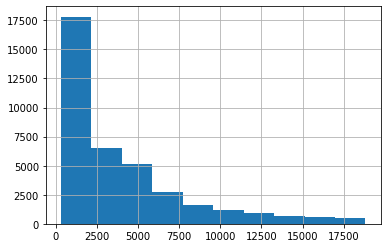

In [283]:
y_train.hist()

This might be a reason for the really big error. The prices are only sometimes really high, so for them the estimator might be less acurate.

Let's calculate the result for all entires, where target costs no more than 7k.

In [342]:
y_test = y_test.reset_index(drop=True)

test_lower_indices = y_test.index[y_test < 7000]
X_test_stripped = X_test_transformed[test_lower_indices,:]
y_test_stripped = y_test[test_lower_indices]

In [343]:
prediction = rfr_estimator.predict(X_test_stripped)

In [344]:
np.sqrt(np.sum(np.square(y_test_stripped - prediction))/len(y_test_stripped))

205.5787230549843

It looks like the error depends mostly on the price of the diamond itself, which is not a huge problem at all. Let's see how it handles larger prices.

In [354]:
y_test = y_test.reset_index(drop=True)

test_lower_indices = y_test.index[y_test < 14000]
X_test_stripped = X_test_transformed[test_lower_indices,:]
y_test_stripped = y_test[test_lower_indices]

In [355]:
prediction = rfr_estimator.predict(X_test_stripped)

In [356]:
np.sqrt(np.sum(np.square(y_test_stripped - prediction))/len(y_test_stripped))

348.6796525101745

Error is bigger as expected.

Now instead of calculating the mean squared error, I will calculate absolute relative error for a little more insight about the regressor.

In [357]:
prediction = rfr_estimator.predict(X_test_transformed)

In [361]:
np.mean(np.abs(prediction-y_test)/y_test)

0.04497363864923825

On average, the regressor makes a 4.5% error during prediction. Even though the MSE is relatively high, the relative error is acceptable, since there are some big-target entries in the dataset.